# NLLB-200 Training Data Size Estimation

There are no official numbers about the amount of data for each language which was used to train the NLLB-200 model. Therefore, here I attempt to estimate the distribution over the languages.

Training data consists of the following portions:

- Primary bitext
    - Public data
    - Seed data
- Mined bitext
- Backtranslated bitext

For more information on NLLB-200 training data, see https://github.com/facebookresearch/fairseq/tree/nllb/examples/nllb/data.

In [7]:
import json
import os
import re
from collections import defaultdict
from urllib.request import urlretrieve

import matplotlib.pyplot as plt
import pandas as pd

## Primary Bitext

### Public Data

The script `download_parallel_copora.py` handles automatic donwloading of many public MT datasets which were used for training NLLB. The total size of those datasets is ~27.5GB.

In [ ]:
PUBL_DATA_DOWNLOAD_SCRIPT="scripts/download_parallel_corpora.py"
DOWNLOAD_DIRECTORY="/Users/hirak/nllb_train_data/primary/public_data"

python scripts/download_parallel_corpora.py --directory $DOWNLOAD_DIRECTORY

In [2]:
PUBL_PATH = "/Users/hirak/nllb_train_data/primary/public_data"

EXCLUDED_FILES = ["cached_lm_test.en", "test.fm.prob", "get_zero_shot_pairs.py",
                  "zeroshotcorpstats", "README", "train.tsv", ".DS_Store"]

# Mapping of ISO 639-1 codes to ISO 639-3 codes
ISO_MAP = {"bn": "ben", "en": "eng", "gu": "guj", "hi": "hin", "kn": "kan",
           "ml": "mal", "mr": "mar", "or": "ory", "pa": "pan", "ta": "tam",
           "te": "tel", "ur": "urd", "fr": "fra"}

In [ ]:
# NOT FOR USE: an attempt to account for duplicate training data in a language,
# but due to inconsistencies in the data, this was not used

# datasets_publ = sorted(os.listdir(PUBL_PATH))
# datasets_publ.remove(".DS_Store")

# file_paths_publ = []

# for dataset in datasets_publ:
#     dataset_path = os.path.join(PUBL_PATH, dataset)
#     dataset_langs = set()
#     for parent_dir, _, dir_files in os.walk(dataset_path):
#         dir_files = [file for file in dir_files if file not in EXCLUDED_FILES]
#         for file in dir_files:
#             file_lang = file.split(".")[1]
#             file_lang = ISO_MAP.get(file_lang, file_lang)
#             if not file_lang in dataset_langs:
#                 dataset_langs.add(file_lang)
#                 file_path = os.path.join(parent_dir, file)
#                 file_paths_publ.append(file_path)

In [3]:
file_paths_publ = []

for parent_dir, _, dir_file_names in os.walk(PUBL_PATH):
    dir_file_names = [n for n in dir_file_names if n not in EXCLUDED_FILES]
    dir_file_paths = [parent_dir + "/" + name for name in dir_file_names]
    file_paths_publ.extend(dir_file_paths)

In [5]:
lang_sizes_publ = defaultdict(int)

for path in file_paths_publ:
    lang = path.split(".")[-1]
    lang = ISO_MAP.get(lang, lang)
    with open(path) as file:
        num_sents = len(file.readlines())
        lang_sizes_publ[lang] += num_sents

In [24]:
df = pd.DataFrame(lang_sizes_publ.items(), columns=["lang", "num_sents_publ"])
df.sort_values("lang", inplace=True)

In [25]:
df.to_csv("lang_train_size.csv", index=False)

### GERL

The [GELR (Ewe-Eng) dataset](https://www.kaggle.com/yvicherita/ewe-language-corpus) couldn't be automatically donwloaded, as it requires authorization, so it was downloaded manually.

In [14]:
GERL_PATH = "/Users/hirak/nllb_train_data/primary/gerl.json"

In [ ]:
gerl = json.load(open(GERL_PATH))
data = gerl[2]["data"]

In [31]:
num_sents_gerl = 0

for pair in data:
    if pair["ee_sentence"] and pair["eng_sentence"]:
        num_sents_gerl += 1

### Seed

There are 6193 sentences for each language. More information can be found here: https://github.com/facebookresearch/flores/tree/main/nllb_seed.

In [9]:
df = pd.read_csv("lang_train_size.csv")

In [3]:
SEED_PATH = "/Users/hirak/nllb_train_data/primary/seed"

In [10]:
file_paths_seed = []

for parent_dir, _, dir_file_names in os.walk(SEED_PATH):
    dir_file_paths = [parent_dir + "/" + name for name in dir_file_names]
    file_paths_seed.extend(dir_file_paths)

In [11]:
lang_sizes_seed = defaultdict(int)

for path in file_paths_seed:
    lang = path.split("/")[-1]
    with open(path) as file:
        num_sents = len(file.readlines())
        lang_sizes_seed[lang] = 6193

In [ ]:
for lang, size in lang_sizes_seed.items():
    if lang in df["lang"].values:
        df.loc[df["lang"] == lang, "num_sents_seed"] = size
    else:
        df = df.append({"lang": lang, "num_sents_seed": size}, ignore_index=True)

In [13]:
df.fillna(0, inplace=True)
df = df.astype({"num_sents_publ": int, "num_sents_gerl": int})
df.sort_values("lang", inplace=True, ignore_index=True)

In [14]:
df.to_csv("lang_train_size.csv", index=False)

## Mined Bitext

### Retrieving Metadata URLs

In [50]:
README_PATH = "/Users/hirak/nllb_train_data/mined/README.md"

url_re = re.compile(
    r"https://dl.fbaipublicfiles.com/nllb/data/\w{3}_\w{4}-\w{3}_\w{4}.meta.v1.xz"
)

In [51]:
with open(README_PATH) as f:
    readme = f.read()

urls = url_re.findall(readme)

with open("mined_metadata_urls.txt", "w") as f:
    for url in urls:
        f.write(url + "\n")

In [ ]:
sbatch scripts/get_lang_sizes_mined.sh

## Backtranslated Text

Although the official NLLB repository provides a script for constructing aligned sentence pairs via backtranslation for a given dataset, there's no information about which specific datasets were backtranslated and used for training the NLLB model. The NLLB training data therefore is estimated without accounting for backtranslated data.

## Summary

In [5]:
df = pd.read_csv("estimates/lang_train_size.csv")

In [5]:
df["num_sents_total"] = (df["num_sents_publ"] + df["num_sents_seed"]
                         + df["num_sents_gerl"] + df["num_sents_mined"])

In [10]:
df["fraction_total"] = df["num_sents_total"] / df["num_sents_total"].sum()

In [19]:
df.to_csv("lang_train_size.csv", index=False)

## Plotting

In [6]:
df_no_eng = df[df["lang"] != "eng_Latn"]

<AxesSubplot: ylabel='lang'>

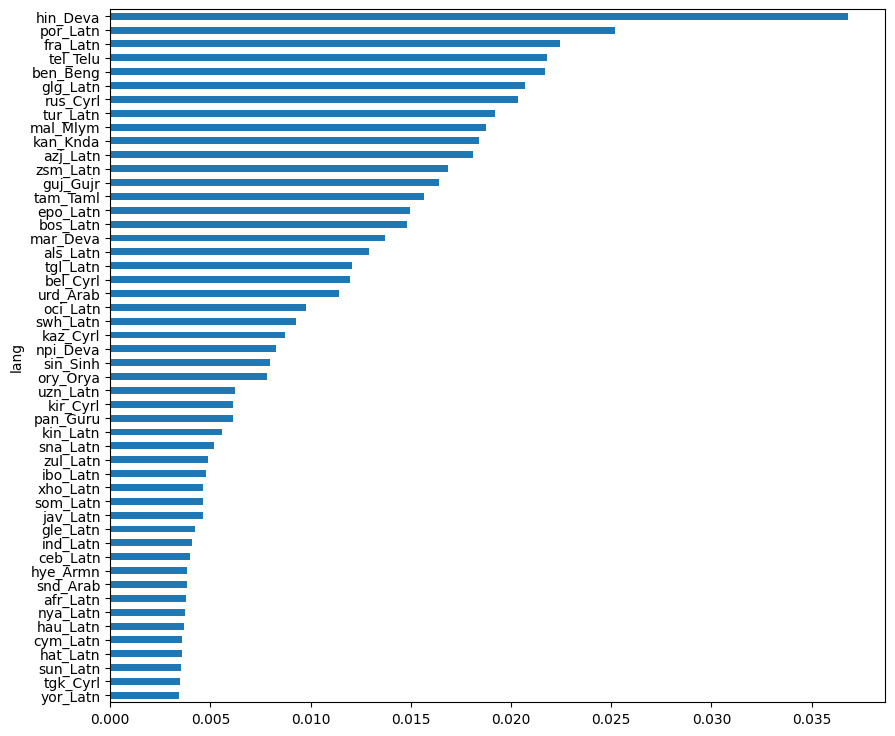

In [19]:
df_sorted = df_no_eng.sort_values("fraction_total", ascending=True)
# Keep only top 50 rows
df_sorted = df_sorted.tail(50)
df_sorted.plot.barh(x="lang", y="fraction_total", figsize=(10, 9), legend=False)

## Wikipedia

In [92]:
lang_data = pd.read_csv("../lang_data/lang_data.csv")

In [94]:
len(lang_data[lang_data["wiki_size"] > 0])

165

In [40]:
wiki_data = (
    pd.read_csv("wiki_data.csv")
    .rename(columns={"Language": "wiki_name", "Articles": "wiki_size"})
)

In [41]:
wiki_data["wiki_size"] = wiki_data["wiki_size"].str.replace(",", "").astype(int)

In [24]:
missing = set(lang_data["name"]) - set(wiki_data["name"])

In [25]:
missing

{'Acehnese (Arabic script)',
 'Acehnese (Latin script)',
 'Akuapem Twi',
 'Asante Twi',
 'Ayacucho Quechua',
 'Banjar (Jawi script)',
 'Bemba',
 'Bengali',
 'Bodo',
 'Central Kanuri (Arabic script)',
 'Central Kanuri (Latin script)',
 'Chhattisgarhi',
 'Chokwe',
 'Dari',
 'Dogri',
 'Dyula',
 'Eastern Panjabi',
 'Filipino',
 'Ilocano',
 'Jingpho',
 'Kabiyè',
 'Kabuverdianu',
 'Kamba',
 'Kashmiri (Arabic script)',
 'Kimbundu',
 'Kituba (DRC)',
 'Levantine Arabic (North)',
 'Levantine Arabic (South)',
 'Luba-Kasai',
 'Luo',
 'Magahi',
 'Mandarin Chinese (Standard Beijing)',
 'Maori',
 'Meadow Mari',
 'Meitei (Manipuri, Bengali script)',
 'Meitei (Manipuri, Meitei script)',
 'Mesopotamian Arabic',
 'Minangkabau (Jawi script)',
 'Mizo',
 'Modern Standard Arabic',
 'Modern Standard Arabic (Romanized)',
 'Mossi',
 'Najdi Arabic',
 'Nko',
 'Nuer',
 'Paraguayan Guaraní',
 'Sindhi (Arabic script)',
 'Tamasheq (Latin script)',
 'Tamasheq (Tifinagh script)',
 'Taʽizzi-Adeni Arabic',
 'Umbundu'}

In [7]:
wiki_data.dtypes

№                    int64
Language            object
Language (local)    object
Wiki                object
Articles            object
All pages           object
Edits               object
Admins               int64
Users               object
Active users        object
Files               object
Depth               object
dtype: object

In [27]:
# Mapping from Wikipeda language names to lang_data language names
NAME_MAP = {
    "Albanian": "Albanian (Tosk)",
    "Banjar": "Banjar (Jawi script)",
    "Banjar": "Banjar (Latin script)",
    "Aymara": "Central Aymara",
    "Yiddish": "Eastern Yiddish",
    "Mongolian": "Halh Mongolian",
    "Kashmiri": "Kashmiri (Arabic script)",
    "Kashmiri": "Kashmiri (Devanagari script)",
    "Khmer": "Khmer (Central)",
    "Tibetan": "Lhasa Tibetan",
    "Ligurian": "Ligurian (Genoese)",
    "Chinese": "Mandarin Chinese (Standard Beijing)",
    "Chinese": "Mandarin Chinese (Taiwanese)",
    "Minangkabau": "Minangkabau (Jawi script)",
    "Minangkabau": "Minangkabau (Latin script)",
    "Arabic": "Modern Standard Arabic",
    "Arabic": "Modern Standard Arabic (Romanized)",
    "Arabic": "Najdi Arabic",
    "Fula": "Nigerian Fulfulde",
    "Azerbaijani": "North Azerbaijani",
    "Kurdish": "Northern Kurdish",
    "Uzbek": "Northern Uzbek",
    "Norwegian": "Norwegian Bokmål",
    "Malagasy": "Plateau Malagasy",
    "Portuguese": "Portuguese (Brazilian)",
    "Sindhi": "Sindhi (Arabic script)",
    "Sindhi": "Sindhi (Devanagari script)",
    "Pashto": "Southern Pashto",
    "Dinka": "Southwestern Dinka",
    "Spanish": "Spanish (Latin American)",
    "Latvian": "Standard Latvian",
    "Malay": "Standard Malay",
    "Arabic": "Tunisian Arabic",
    "Oromo": "West Central Oromo",
    "Persian": "Western Persian",
    "Cantonese": "Yue Chinese (Hong Kong Cantonese)",
    "Twi": "Akuapem Twi",
    "Twi": "Asante Twi",
    "Quechua": "Ayacucho Quechua",
    "Eastern Mari": "Meadow Mari",
    "Manipuri": "Meitei (Manipuri, Bengali script)",
    "Manipuri": "Meitei (Manipuri, Meitei script)",
    "Arabic": "Mesopotamian Arabic"
}

In [28]:
# Rerverse mapping
NAME_MAP = {v: k for k, v in NAME_MAP.items()}

In [32]:
lang_data["wiki_name"] = [NAME_MAP.get(name, name) for name in lang_data["name"]]

In [46]:
lang_data = lang_data.merge(wiki_data[["wiki_name", "wiki_size"]], on="wiki_name", how="left")

In [48]:
# Fill missing values in wiki_size with 0
lang_data["wiki_size"] = lang_data["wiki_size"].fillna(0)

In [51]:
lang_data.drop(columns=["wiki_name"], inplace=True)

In [52]:
lang_data.to_csv("lang_data.csv", index=False)

### Histogram of Wiki Sizes

In [3]:
lang_data = pd.read_csv("../lang_subsets/langs_124.csv")

In [4]:
lang_data_sorted = (
    lang_data[lang_data["wiki_size"] > 0]
    .sort_values("wiki_size", ascending=True)
)

In [5]:
lang_data_sorted["wiki_size"] = lang_data_sorted["wiki_size"] / 1_000_000

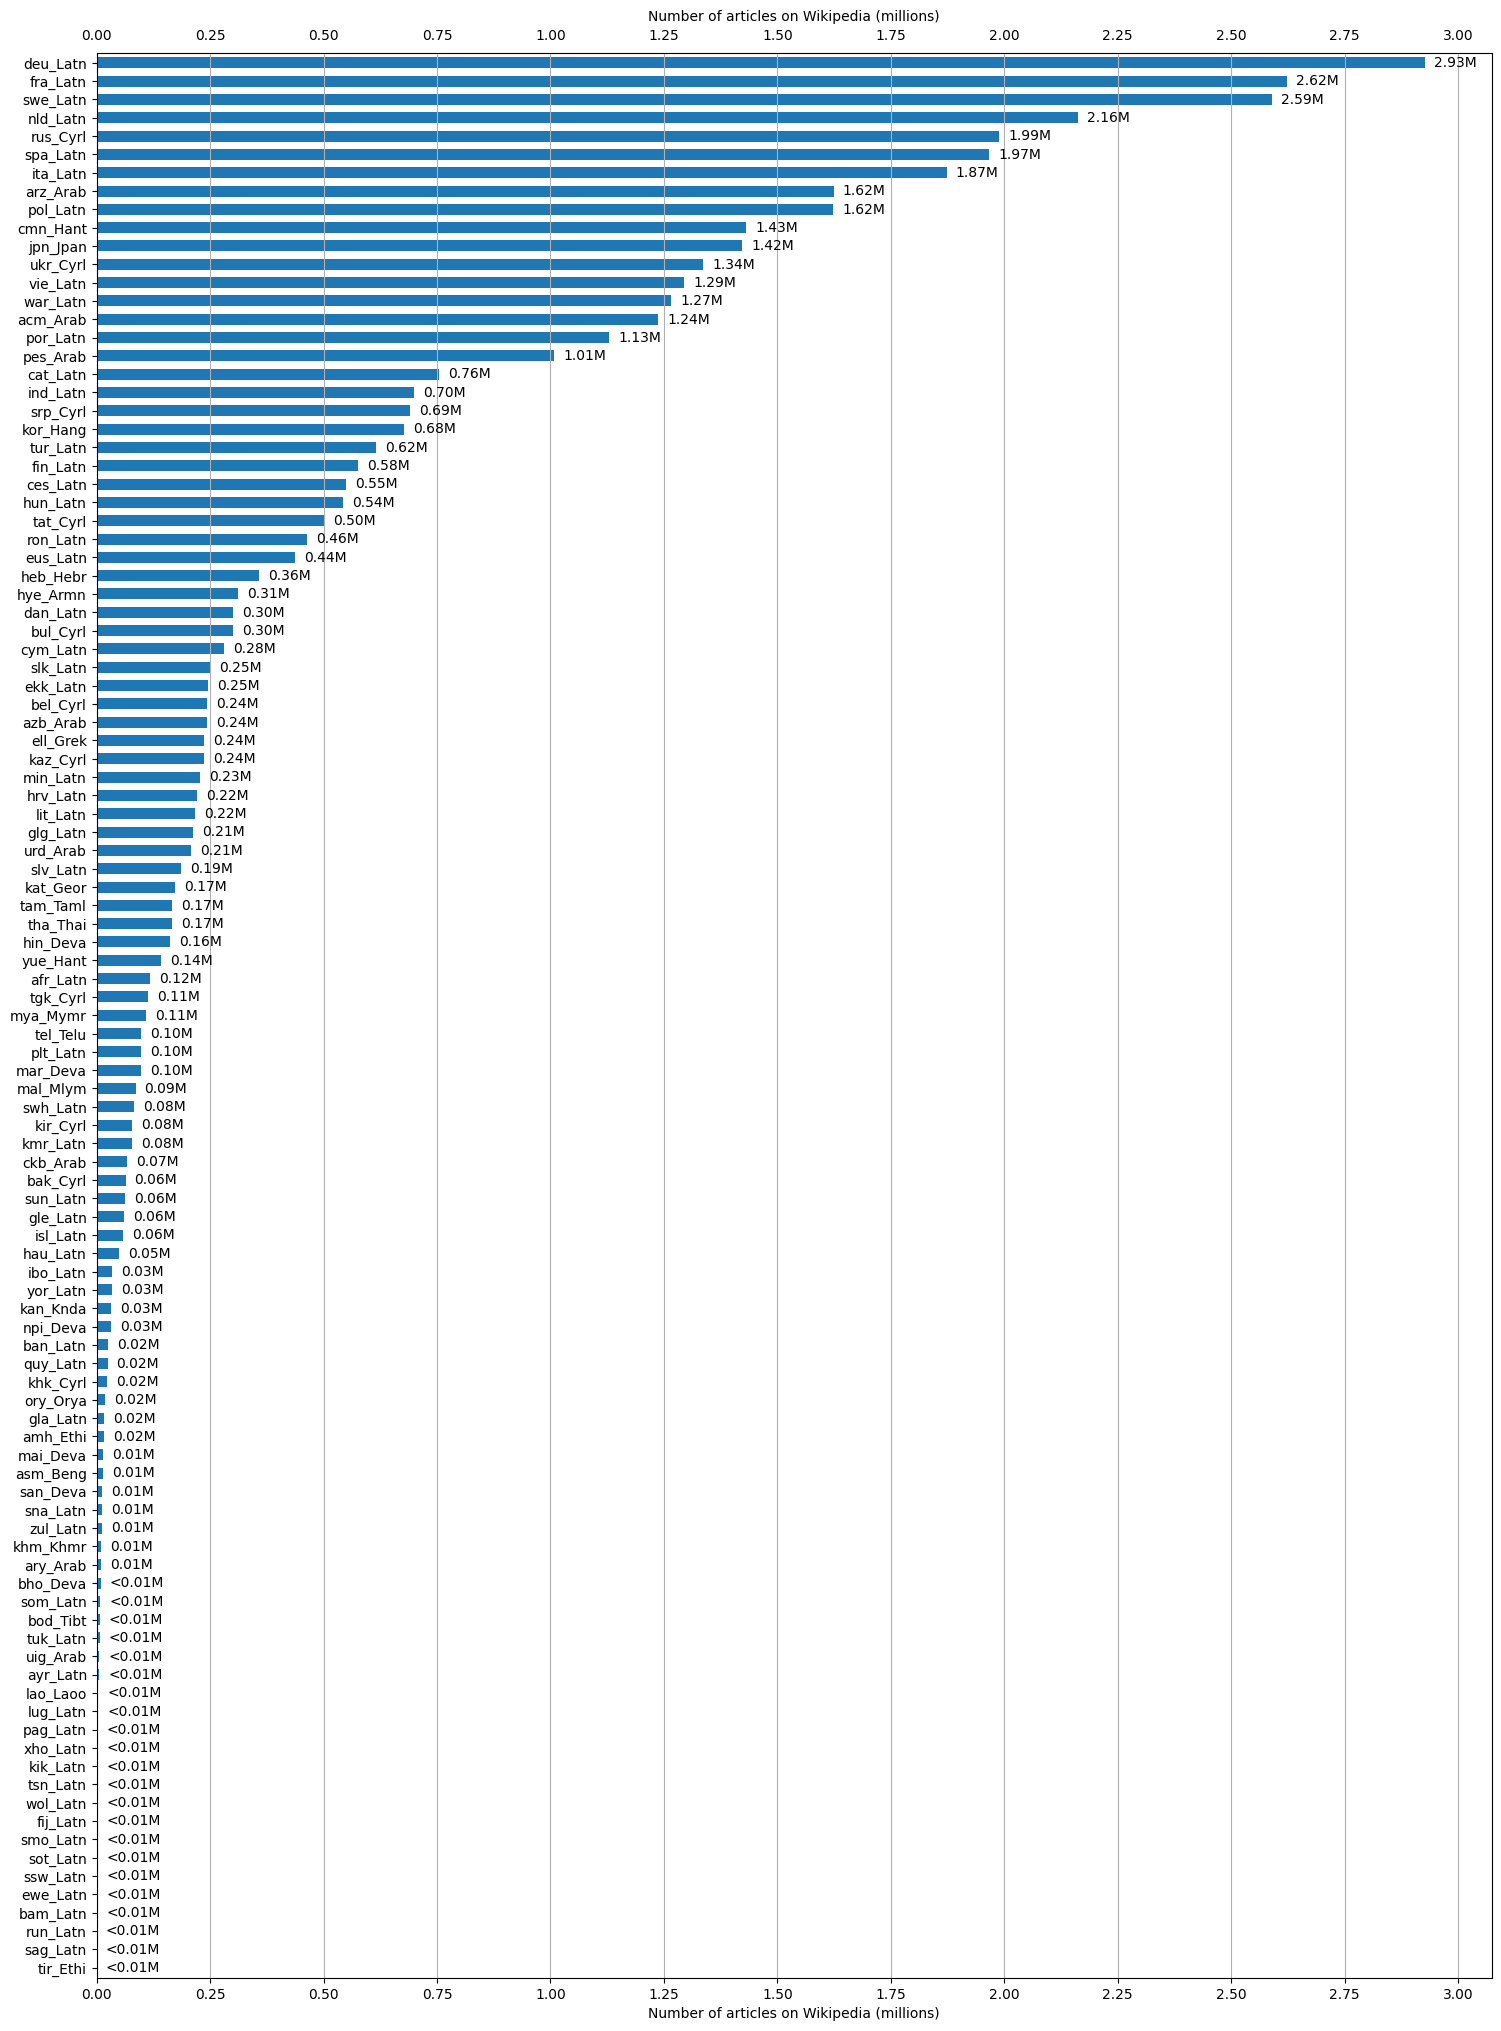

In [18]:
import numpy as np
import pandas as pd

ax = lang_data_sorted.plot.barh(
    figsize=(18, 25),
    x="lang",
    y="wiki_size",
    legend=False,
    xlabel="Number of articles on Wikipedia (millions)",
    ylabel="",
    width=0.6,
)

ax.set_title("Number of articles on Wikipedia (millions)", fontsize=10)

for idx, value in enumerate(lang_data_sorted["wiki_size"]):
    annotation = "<0.01M" if value < 0.01 else f"{value:.2f}M"
    ax.text(value + 0.02, idx, annotation, fontsize=10, va="center")

ax.set_xticks(np.arange(0, 3.1, 0.25))
ax.tick_params(axis='x', which='both', labeltop=True, labelbottom=True, labelsize=10)

# # Create a twin x-axis to add xlabel at the top
# ax_top = ax.twiny()
# ax_top.set_xlabel("Number of articles on Wikipedia (millions)")
# ax_top.xaxis.set_ticks_position('top')
# ax_top.xaxis.set_label_position('top')
# ax.set_xticks(np.arange(0, 3.1, 0.25))
# ax.tick_params(axis='x', which='both', labeltop=True, labelbottom=True)

# # Synchronize the x-axis limits and ticks
# ax_top.set_xlim(ax.get_xlim())
# ax_top.set_xticks(ax.get_xticks())
# ax_top.set_xticklabels([])

ax.grid(True, axis="x")
plt.yticks(fontsize=10)
plt.savefig("wiki_size.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [91]:
len(lang_data_sorted)

105